In [3]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_features_vmd_fft')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_features_vmd_fft')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_features_vmd_fft')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


# 定义 通道注意力机制

In [4]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 全局平均池化  x: torch.Size([256, 128, 121])
        out = self.avg_pool(x)
        out = out.view(out.size(0), -1)
        # Squeeze阶段：通过全连接层降维
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        # Excitation阶段：通过Sigmoid函数生成权重
        out = self.sigmoid(out)  # out: torch.Size([256, 128])
        out = out.view(out.size(0), out.size(1), -1)
        # 乘以权重，实现通道的重新加权
        out = x * out
        return out

# 2DSWinTransfromer-1DCNN并行分类模型

In [5]:
import torch.nn as nn
import torch
from timm.models.swin_transformer import SwinTransformer

class SwinCNNSEModel(nn.Module):
    def __init__(self,  conv_archs, input_dim, output_dim, *args, **kwargs):
        super().__init__()

        # SwinTransformer特征提取
        self.swmodel = SwinTransformer(*args, **kwargs)

        # cnn 1D 卷积池化网络结构 + 通道注意力机制 参数
        self.conv_archs =  conv_archs  # cnn 1D 卷积池化网络结构
        self.input_channels = input_dim  # 分支 CNN输入通道数  默认三通道 输入数据
        self.cnn1d_globalfeatures = self.make_1dcnn_layers()  # 1D 卷积池化 + 通道注意力机制

        # 自适应平均池化
        self.adaptive_pool_2D = nn.AdaptiveAvgPool2d((1, 1))

        self.adaptive_pool_1D = nn.AdaptiveAvgPool1d(1)

        # 定义全连接层
        self.classifier = nn.Linear(conv_archs[-1][-1] + 64 , output_dim)

    # CNN 全局注意力机制 卷积池化结构
    def make_1dcnn_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_archs:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                layers.append(SEBlock(out_channels))  # 添加通道注意力机制
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))  # 添加池化层
        return nn.Sequential(*layers)

    def forward(self, input):

        # input :  torch.Size([64, 5, 1024])
        batch_size = input.size(0)
        input_dim = input.size(1)

        # 分支一：2D - SwinTransformer
        #改变输入形状，适应网络输入[batch, channels, width, height]
        # 注意：这里是 把数据进行了堆叠 把一个1*1024 的序列 进行 划分堆叠成形状为 32 * 32， 就使输入序列的长度降下来了  适应 SwinTransformer 输入
        swin_input = input.view(batch_size, input_dim, 32, 32)
        # 空间特征局部 SWinTransformer
        swin_features = self.swmodel.forward_features(swin_input)
        # print(swin_features.size())  #   torch.Size([64, 8, 8, 64])
        swin_features = swin_features.permute(0, 3, 1, 2)  # torch.Size([64, 64, 8, 8])
        # 自适应平均池化
        swin_adaptive_pool = self.adaptive_pool_2D(swin_features)
        # print(swin_adaptive_pool.size())  torch.Size([64, 64, 1, 1])
        # 维度压缩
        swin_out = swin_adaptive_pool.view((batch_size, -1)) # torch.Size([64, 64]

        # 分支二：1D - CNN
        # 空间全局特征 卷积池化处理
        #  输入 （batch_size, channels, length）
        cnn1d_globalfeatures = self.cnn1d_globalfeatures(input)
        # print(cnn1d_globalfeatures.size())  # torch.Size([64, 128, 128])
         # 自适应平均池化
        cnn1d_adaptive_pool = self.adaptive_pool_1D(cnn1d_globalfeatures)
        # print(cnn1d_adaptive_pool.size()) # torch.Size([64, 128, 1])
        # 维度压缩
        cnn1d__out = cnn1d_adaptive_pool.view((batch_size, -1)) # torch.Size([64, 128]

        # 模型堆叠融合
        combined_features = torch.cat((swin_out, cnn1d__out), dim=1)  # torch.Size([64, 128 + 64]
        outputs = self.classifier(combined_features)  # torch.Size([64, 5]
        return outputs


In [6]:
# 定义模型参数
num_classes = 5 # 5分类
# 1D-CNN 参数
# VGG11，VGG13，VGG16，VGG19 可自行更换。
#conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  # vgg11
#conv_arch = ((2, 64), (2, 128), (2 , 256), (2, 512), (2, 512))  # vgg13
#conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))  # vgg16
#conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))  # vgg19
# 先用浅层试一试
conv_archs = ((1, 32), (1, 64), (1, 128))  
input_dim = 5  # 输入 5 个通道
output_dim = 5 # 5分类

# Swin Transformer 参数
img_size = 32  # 输入图像尺寸为 32x32
patch_size = 4  # 补丁尺寸为 4x4
embed_dim = 100
# depths = (2, 2, 6, 2)  原始论文参数
# num_heads = (3, 6, 12, 24) 原始论文参数
depths = (1,)
num_heads = (4,)         # 层数 和每层 注意力头数 可灵活设置
# depths = (1, 1, 1, 1)
# num_heads = (3, 6, 12, 24)
window_size=4,  # 窗口尺寸为 8x8，32 的约数
mlp_ratio = 2.0

 # 定义模型
# 创建 SwinCNNGAModel 模型
model = SwinCNNSEModel(
    conv_archs, input_dim, output_dim,   # 1D-CNN 参数
    img_size=img_size,  # 输入图像尺寸为 224x224
    patch_size=patch_size,  # 补丁尺寸为 4x4
    in_chans=input_dim,  # 输入通道数为 5
    num_classes=num_classes,  #  5 个类别
    embed_dim=64,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,  # 窗口尺寸为 7X7，224的约数
    mlp_ratio=mlp_ratio,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
)

# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss

learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    # model.parameters()：返回模型中的所有参数。
    # p.numel()：返回参数 p 的元素个数
    # if p.requires_grad：过滤掉那些不需要梯度的参数（即不可训练参数），只保留可训练参数。
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    
    for item in params:
        # {item:>6}：使用格式化字符串，将每个参数数量右对齐并保留 6 个字符宽度
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  5120
    64
    64
    64
    64
    64
   196
 12288
   192
  4096
    64
    64
    64
  8192
   128
  8192
    64
    64
    64
   320
     5
   480
    32
    64
     2
    64
    32
  6144
    64
   256
     4
   256
    64
 24576
   128
  1024
     8
  1024
   128
   960
     5
______
 74748


In [5]:
print(model)

SwinCNNSEModel(
  (swmodel): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(5, 64, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=64, out_features=192, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=64, out_features=64, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=64, out_features=128, bias=

Epoch:  1 train_Loss: 1.28674532 train_Accuracy:0.4916
Epoch:  1 val_Loss:0.84937686,  validate_Acc:0.6497
Epoch:  2 train_Loss: 0.74579564 train_Accuracy:0.6684
Epoch:  2 val_Loss:0.67179277,  validate_Acc:0.6890
Epoch:  3 train_Loss: 0.51174222 train_Accuracy:0.8205
Epoch:  3 val_Loss:0.28487587,  validate_Acc:0.9405
Epoch:  4 train_Loss: 0.21135551 train_Accuracy:0.9441
Epoch:  4 val_Loss:0.17947580,  validate_Acc:0.9551
Epoch:  5 train_Loss: 0.15043975 train_Accuracy:0.9569
Epoch:  5 val_Loss:0.14399691,  validate_Acc:0.9587
Epoch:  6 train_Loss: 0.12376221 train_Accuracy:0.9623
Epoch:  6 val_Loss:0.12145570,  validate_Acc:0.9637
Epoch:  7 train_Loss: 0.11188791 train_Accuracy:0.9647
Epoch:  7 val_Loss:0.11084085,  validate_Acc:0.9688
Epoch:  8 train_Loss: 0.09937616 train_Accuracy:0.9693
Epoch:  8 val_Loss:0.11288742,  validate_Acc:0.9627
Epoch:  9 train_Loss: 0.09591436 train_Accuracy:0.9682
Epoch:  9 val_Loss:0.10009854,  validate_Acc:0.9688
Epoch: 10 train_Loss: 0.08723252 trai

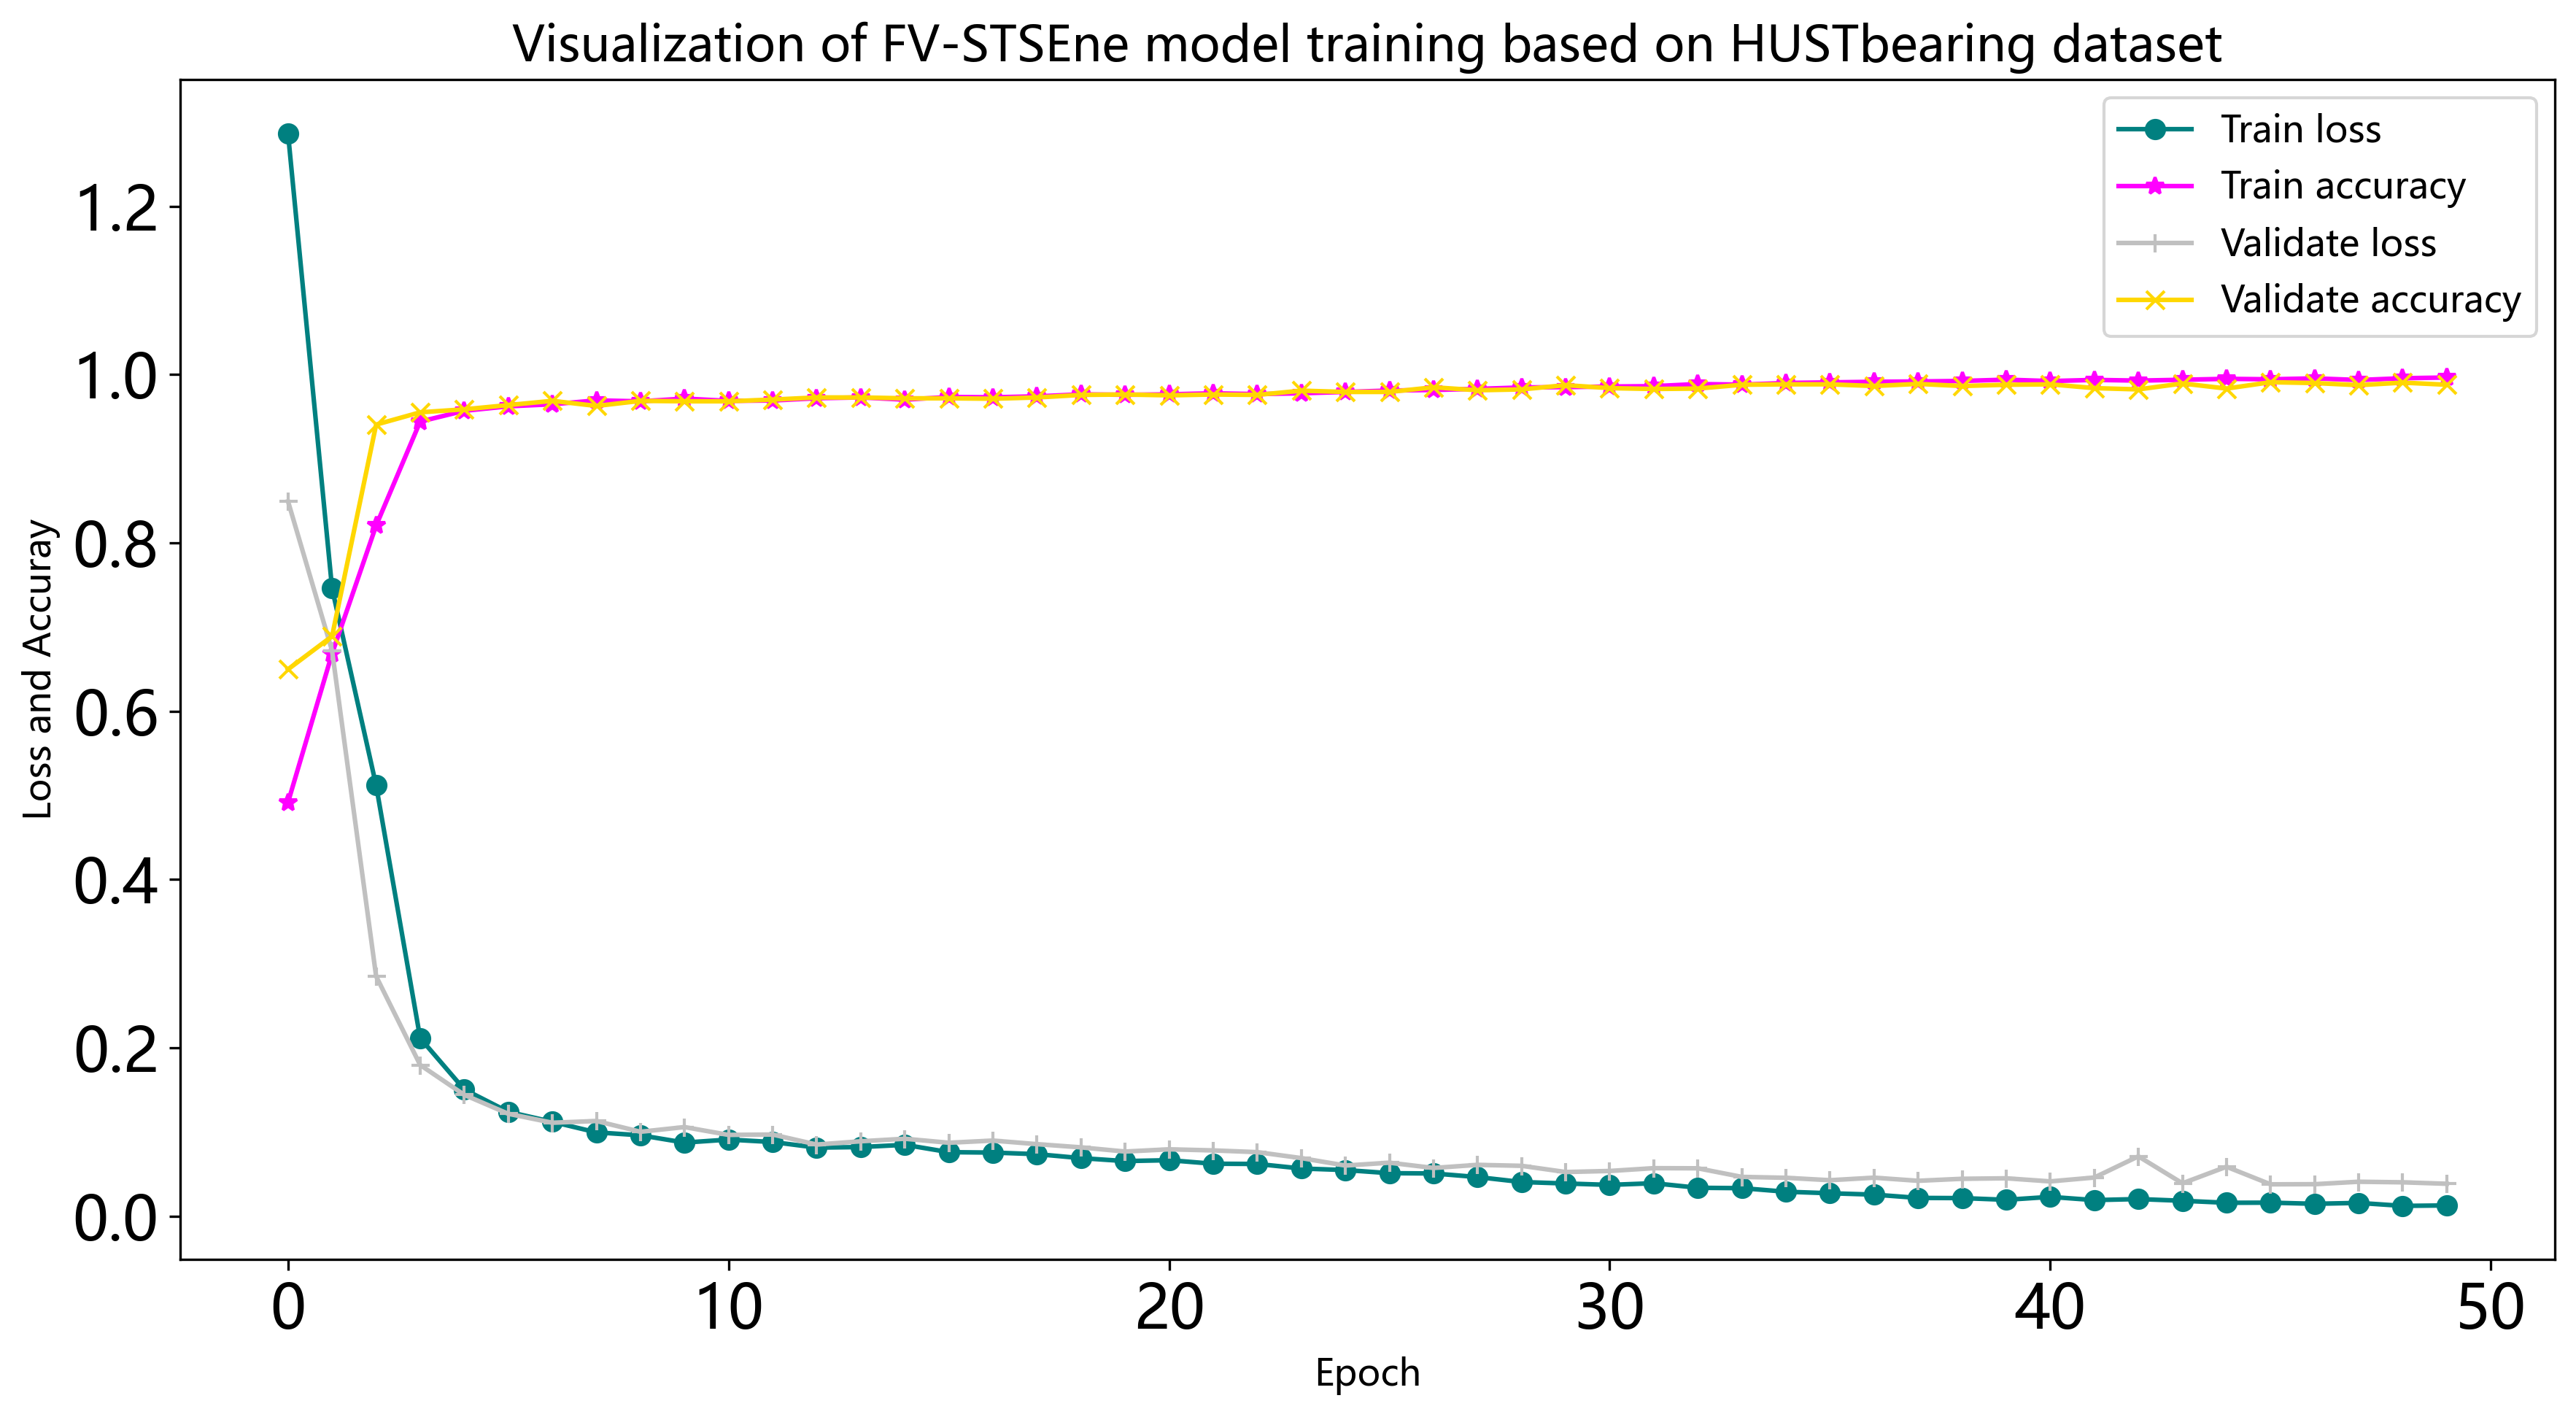

best_accuracy : 0.9909274193548387


In [6]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            # 将模型设置为评估模式
            model.eval()
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_swincnnse.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_swincnnse.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
  
    # 可视化
    # 创建训练损失、准确率图
    plt.figure(figsize=(14, 7), dpi=300)  # dpi 越大  图片分辨率越高，写论文的话 一般建议300以上设置
    plt.plot(range(epochs), train_loss, color = 'teal', marker='o',label = 'Train loss')
    plt.plot(range(epochs), train_acc, color = 'magenta', marker='*',label = 'Train accuracy')
    plt.plot(range(epochs), validate_loss, color = 'silver', marker='+',label = 'Validate loss')
    plt.plot(range(epochs), validate_acc, color = 'gold', marker='x',label = 'Validate accuracy')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss and Accuray', fontsize=12)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=12)
    plt.title('Visualization of FV-STSEne model training based on HUSTbearing dataset', fontsize=16)
    plt.savefig("loss-acc.png")
    plt.show()   #显示 lable 
    # 保存结果 方便 后续画图处理（如果有需要的话）
    dump(train_loss, 'train loss') 
    dump(train_acc, 'train acc') 
    dump(validate_loss, 'validate loss') 
    dump(validate_acc, 'validate acc') 
    
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, train_loader, val_loader, model, optimizer, loss_function)

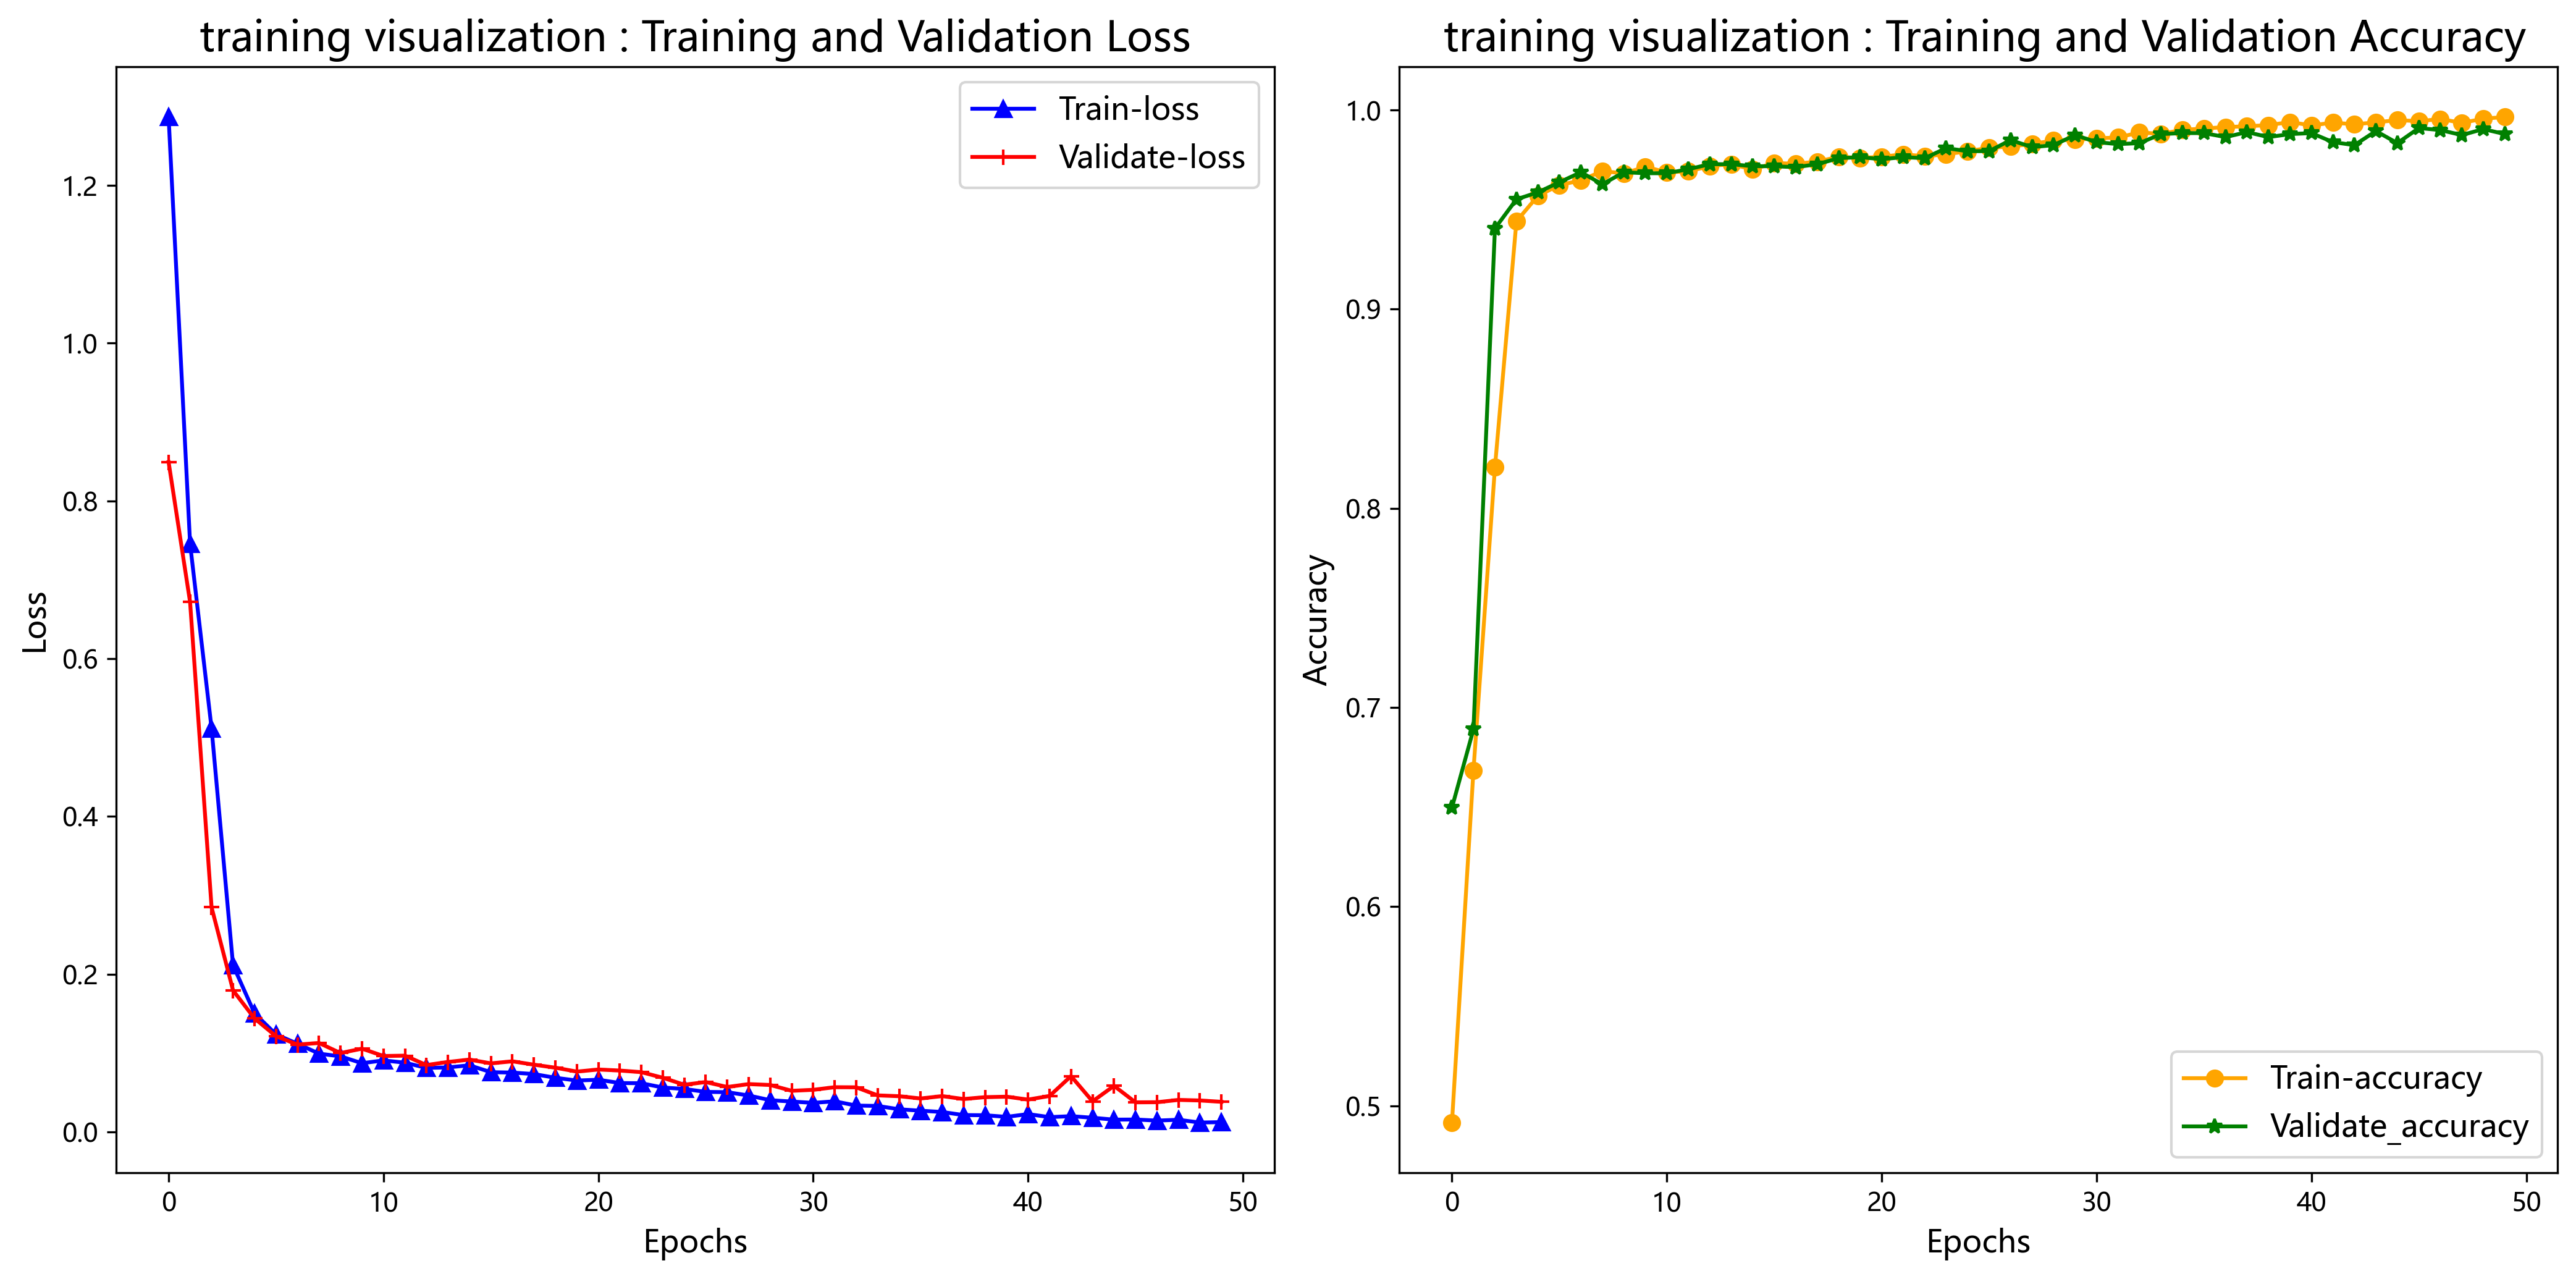

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
matplotlib.rc("font", family='Microsoft YaHei')

# 加载数据
train_loss = load('train loss')
train_acc = load('train acc')

validate_loss = load('validate loss')
validate_acc = load('validate acc')

# 创建训练损失图
# 创建左侧图：损失
plt.figure(figsize=(14, 7), dpi=300)

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train-loss', marker='^', color='blue') # o ^ * s + x   , marker='o'
plt.plot(validate_loss, label='Validate-loss', marker='+', color='red')   # 颜色 曲线类型 可灵活替换
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.title('training visualization : Training and Validation Loss', fontsize=16)

# 创建右侧图：准确率
plt.subplot(1, 2, 2)
plt.plot(train_acc,color = 'orange', marker='o',label = 'Train-accuracy')
plt.plot(validate_acc, color = 'green', marker='*',label = 'Validate_accuracy')


plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.title(' training visualization : Training and Validation Accuracy', fontsize=16)


plt.tight_layout()  # 用于确保子图之间的距离适当
plt.show()

In [9]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
class DualPathAttentionFusion(nn.Module):
    def __init__(self, swin_dim, cnn_dim, hidden_dim=64):
        super().__init__()
        self.swin_attention = nn.Sequential(
            nn.Linear(cnn_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, swin_dim),
            nn.Sigmoid()
        )
        self.cnn_attention = nn.Sequential(
            nn.Linear(swin_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, cnn_dim),
            nn.Sigmoid()
        )
        self.swin_proj = nn.Linear(swin_dim, hidden_dim)
        self.cnn_proj = nn.Linear(cnn_dim, hidden_dim)
        
    def forward(self, swin_feat, cnn_feat):
        swin_feat = swin_feat.unsqueeze(1)
        cnn_feat = cnn_feat.unsqueeze(1)
        swin_att = self.swin_attention(cnn_feat)
        cnn_att = self.cnn_attention(swin_feat)
        swin_weighted = swin_feat * swin_att
        cnn_weighted = cnn_feat * cnn_att
        swin_proj = self.swin_proj(swin_weighted)
        cnn_proj = self.cnn_proj(cnn_weighted)
        combined = (swin_proj + cnn_proj).squeeze(1)
        return combined

# -------------------- 加载模型的正确方法 --------------------
def load_model(model_path):
    # 1. 先实例化模型结构（需与训练时完全一致）
    model = SwinCNNSEModel(...)  # 替换为你的模型初始化参数
    # 2. 加载状态字典
    model.load_state_dict(torch.load(model_path))
    return model

# 加载模型（示例）
#model = load_model("best_model.pth")
#model.eval()

# 得出每一类的分类准确率
model = torch.load('best_model_swincnnse.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
# 使用测试集数据进行推断并计算每一类的分类准确率
true_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

# 提取特征
test_original_labels = []  # 原始测试集 标签
test_model_features = []  # 测试集经过训练后的模型得到的 特征

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_original_labels += test_label.tolist()   # 提取标签

        test_data = test_data.to(device)
        test_output = model(test_data)

        test_model_features += test_output.tolist()  # 提取特征

        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        true_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(true_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22216\2007725694.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_swincnnse.pt')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x192 and 64x5)

In [1]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵的颜色取值
#https://blog.csdn.net/m0_68795816/article/details/125686360

plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of FV-STSEnet-load')
plt.savefig("FV-SASEnet.png")
plt.show()

NameError: name 'confusion_mat' is not defined

<Figure size 1500x1200 with 0 Axes>

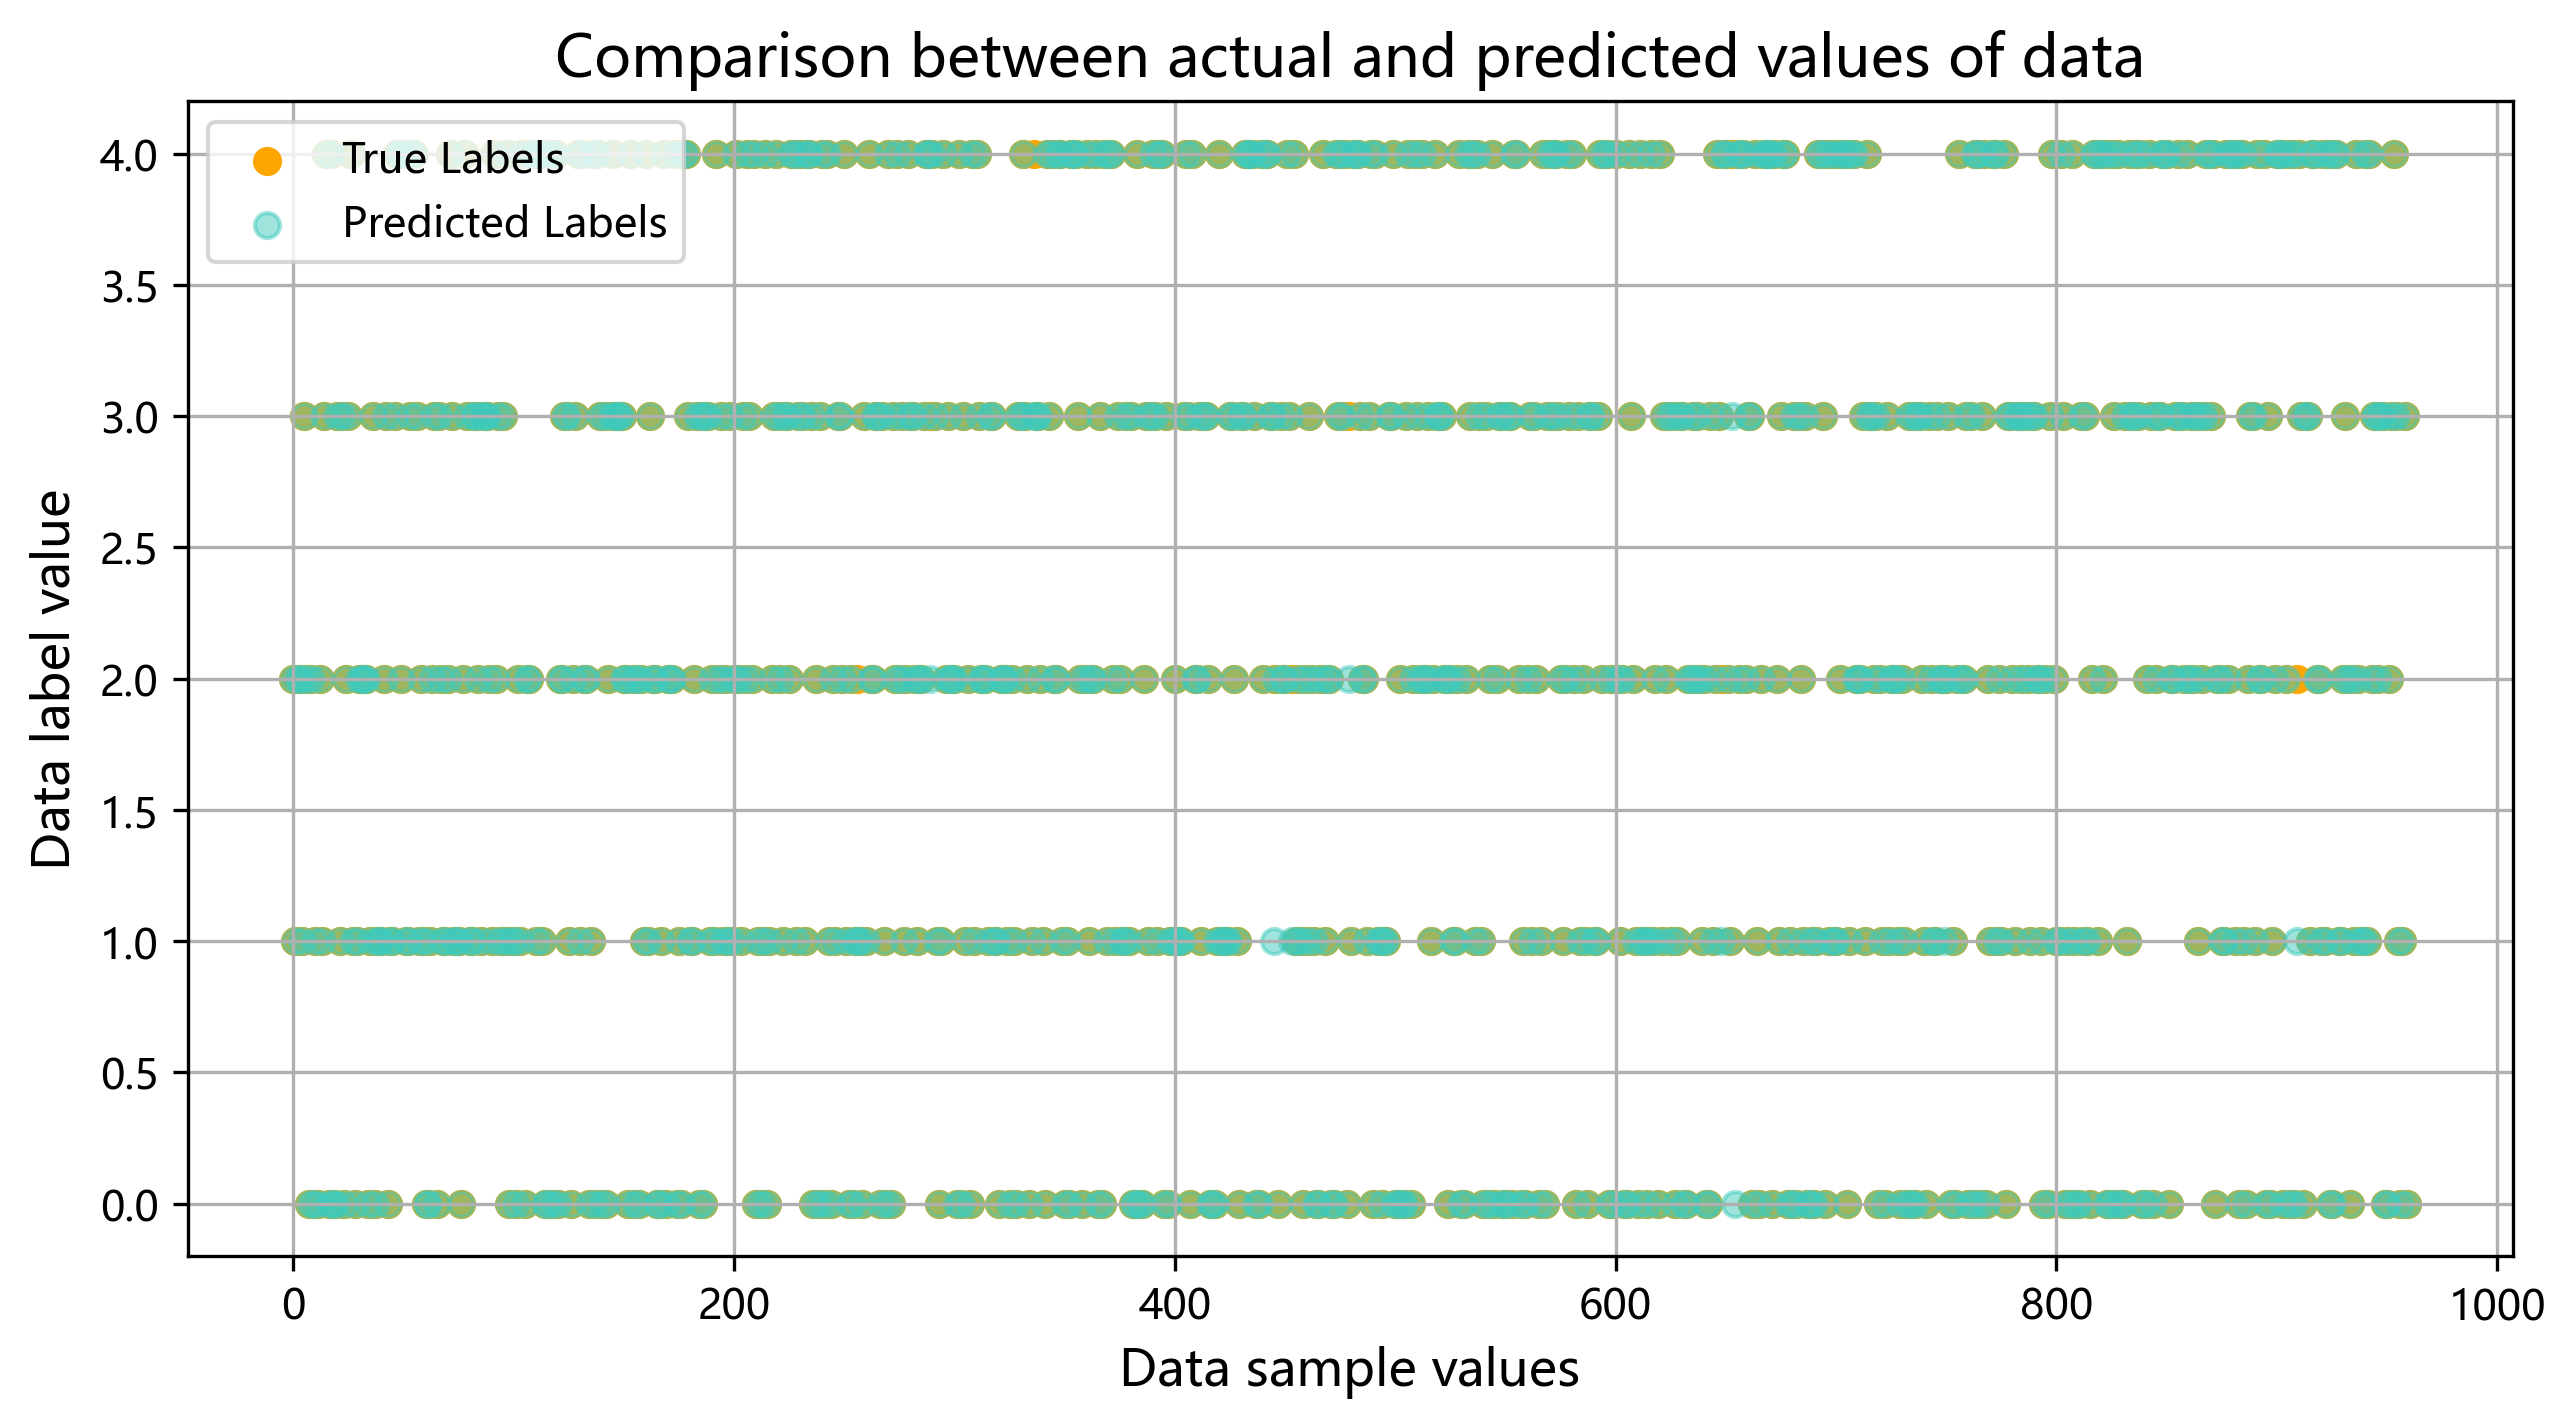

In [19]:
import matplotlib.pyplot as plt

# 类别标签
x = [i for i in range(len(true_labels))]

# 可视化结果
plt.figure(figsize=(10, 5), dpi=300)

# 绘制真实标签的折线图
plt.scatter(x, true_labels,color='orange', label='True Labels', alpha=1)
# 绘制预测标签的折线图
plt.scatter(x, predicted_labels , color='#3ECABD', label='Predicted Labels', alpha=0.5)

# plt.plot(x, class_labels,color='red', label='True Labels', alpha=0.5)
# # 绘制预测标签的折线图
# plt.plot(x, predicted_labels , color='green', label='Predicted Labels')

plt.title('Comparison between actual and predicted values of data', fontsize=14)
plt.xlabel('Data sample values', fontsize=12)
plt.ylabel('Data label value', fontsize=12)
# plt.xticks(class_labels)
plt.legend()
plt.grid(True)
plt.savefig("ture and predicted.png")
plt.show()

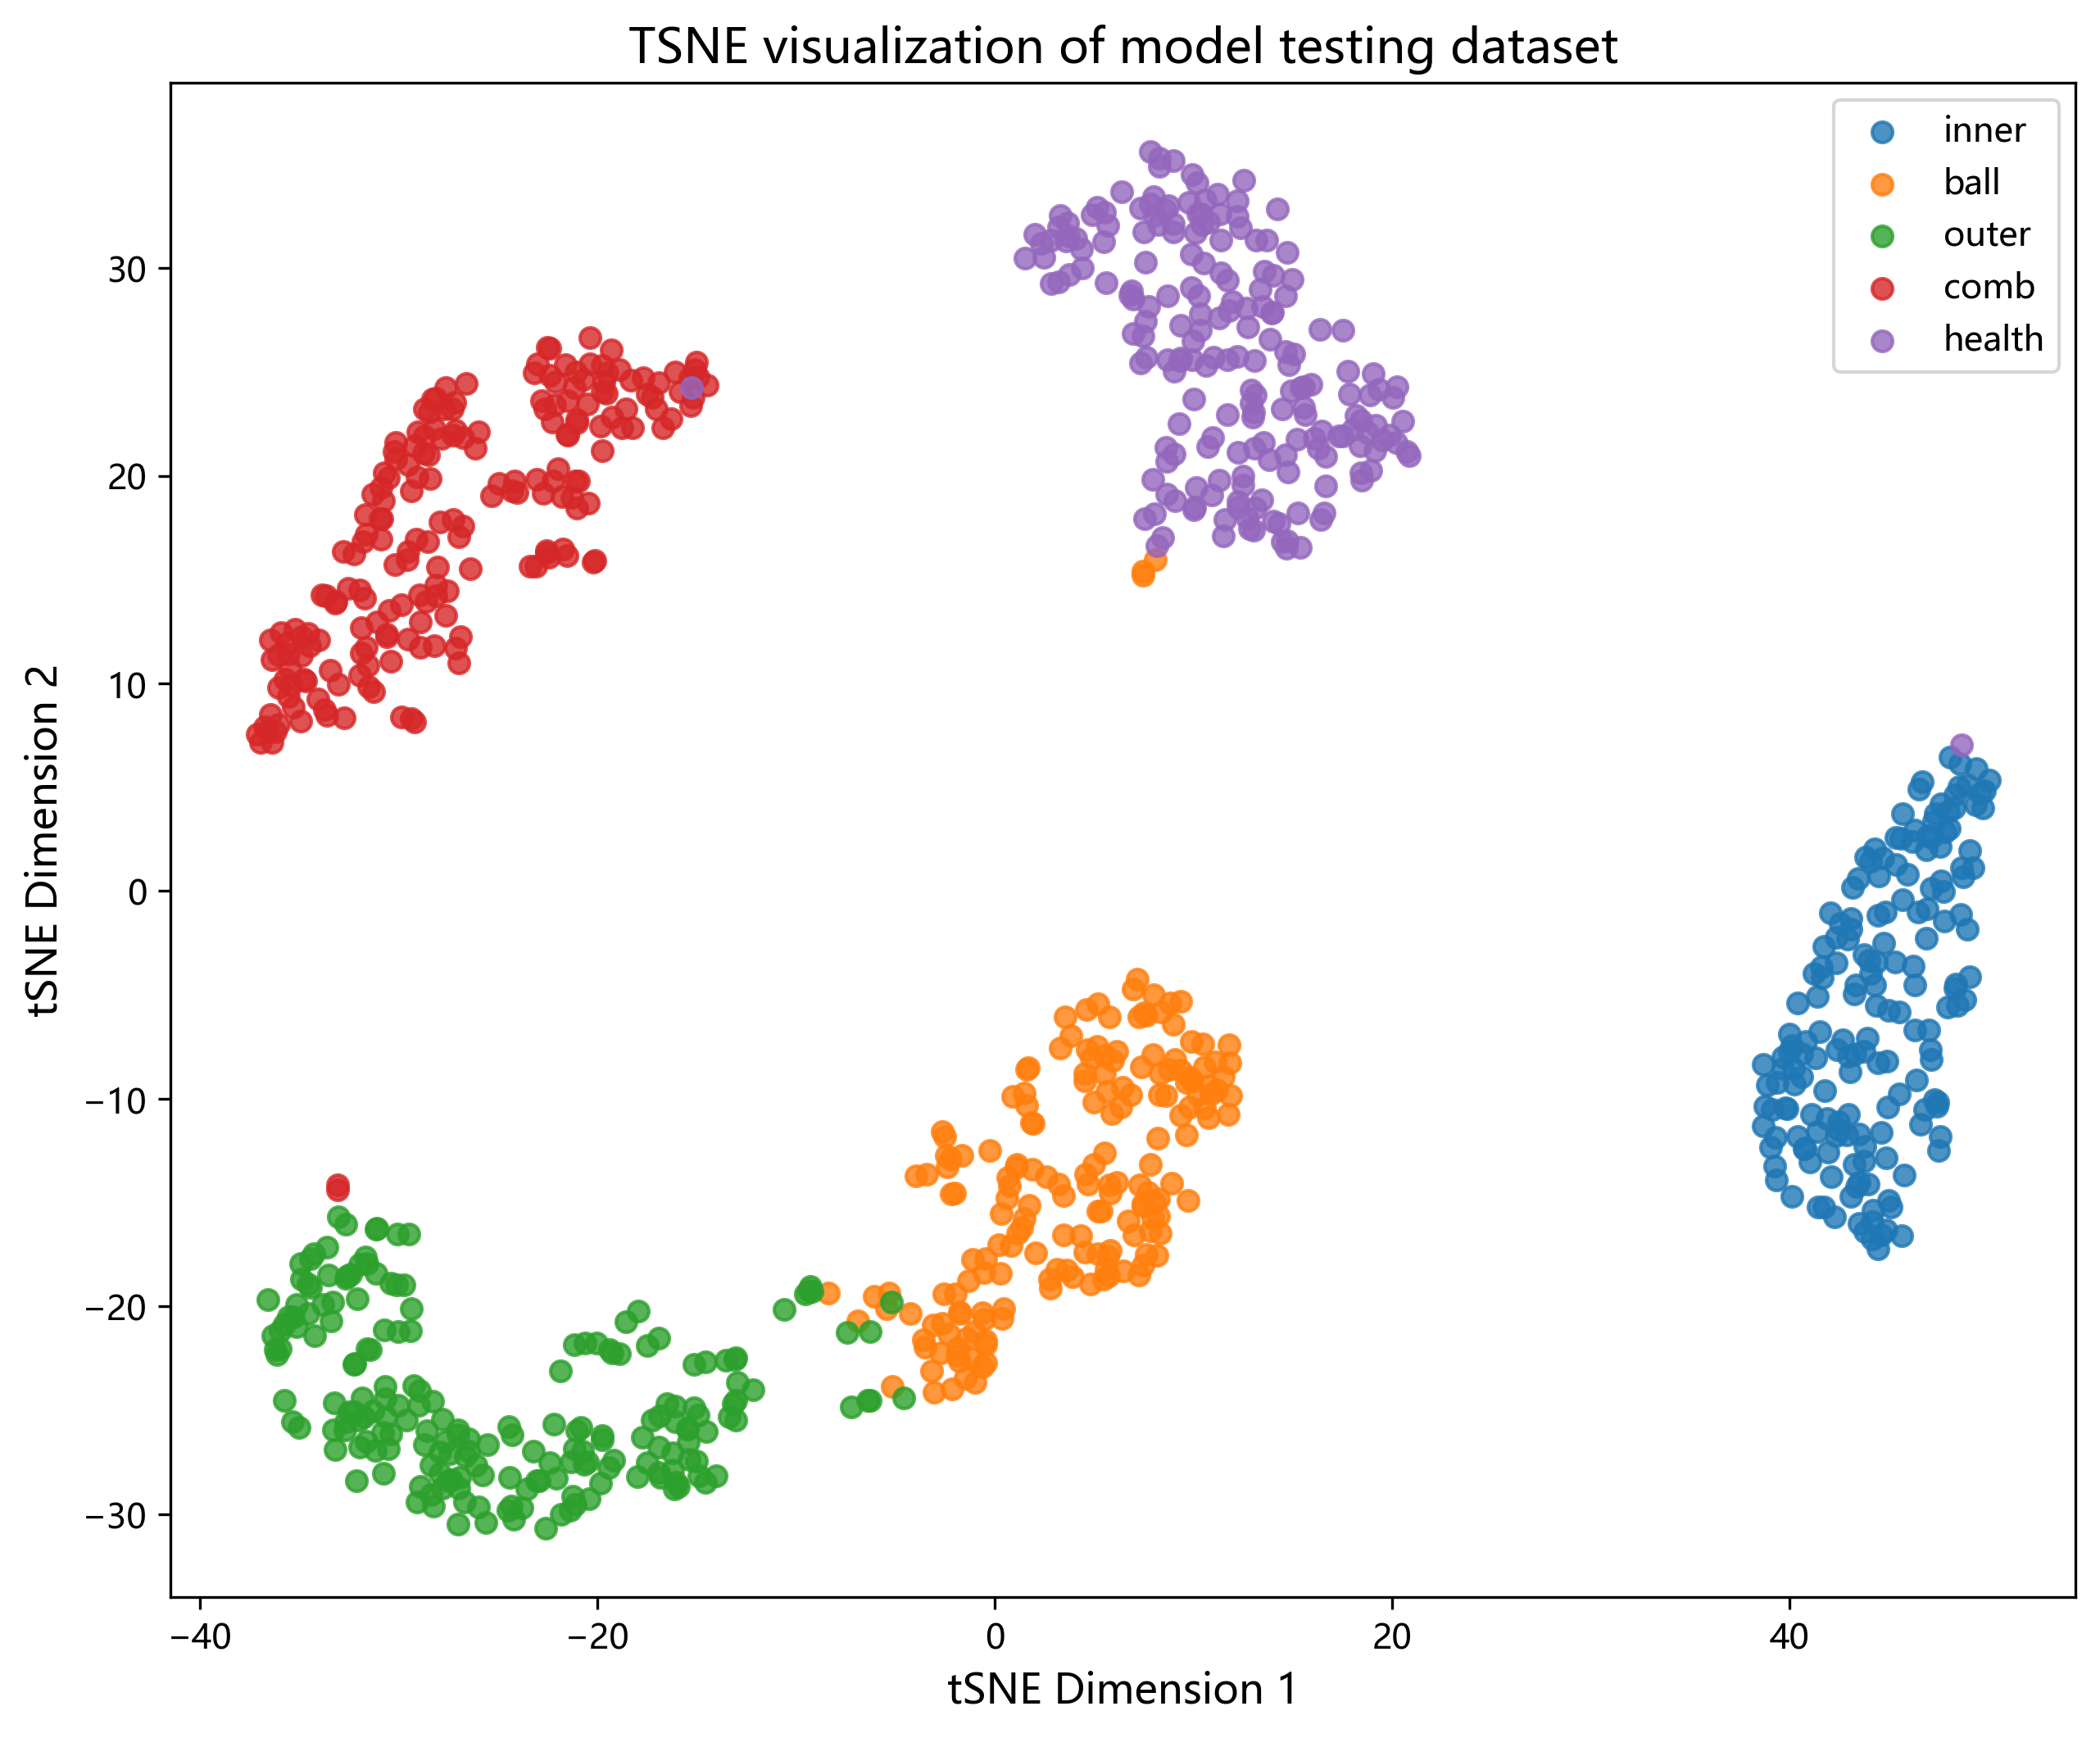

In [20]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
from sklearn.manifold import TSNE

# 训练好的模型 测试集 进行 t-SNE 降维
def plot_model_TSNE(test_model_features, test_original_labels, num_classes, class_labels_name):
    features = np.array(test_model_features)
    labels = np.array(test_original_labels)

    # 初始化 t-SNE 模型
    tsne = TSNE(n_components=2, random_state=42)

    # 对原始数据进行 t-SNE 降维
    features_tsne = tsne.fit_transform(features)

    # 可视化结果
    plt.figure(figsize=(10, 8), dpi=300)
    # 绘制每个类别的散点图，并指定label
    for i in range(num_classes):
        plt.scatter(features_tsne[labels == i, 0], features_tsne[labels == i, 1], label=class_labels_name[i], alpha=0.8)
    plt.title('TSNE visualization of model testing dataset', fontsize=14)
    plt.xlabel('tSNE Dimension 1', fontsize=12)
    plt.ylabel('tSNE Dimension 2', fontsize=12)
    # 显示legend
    plt.legend()
    # plt.show()
    plt.savefig('模型测试集TSNE可视化', dpi=300)


num_classes = 5  # 5分类
# 类别标签
class_labels_name = ['inner','ball','outer','comb','health']

# 训练好的模型 测试集 进行 t-SNE 降维
plot_model_TSNE(test_model_features, test_original_labels, num_classes, class_labels_name)

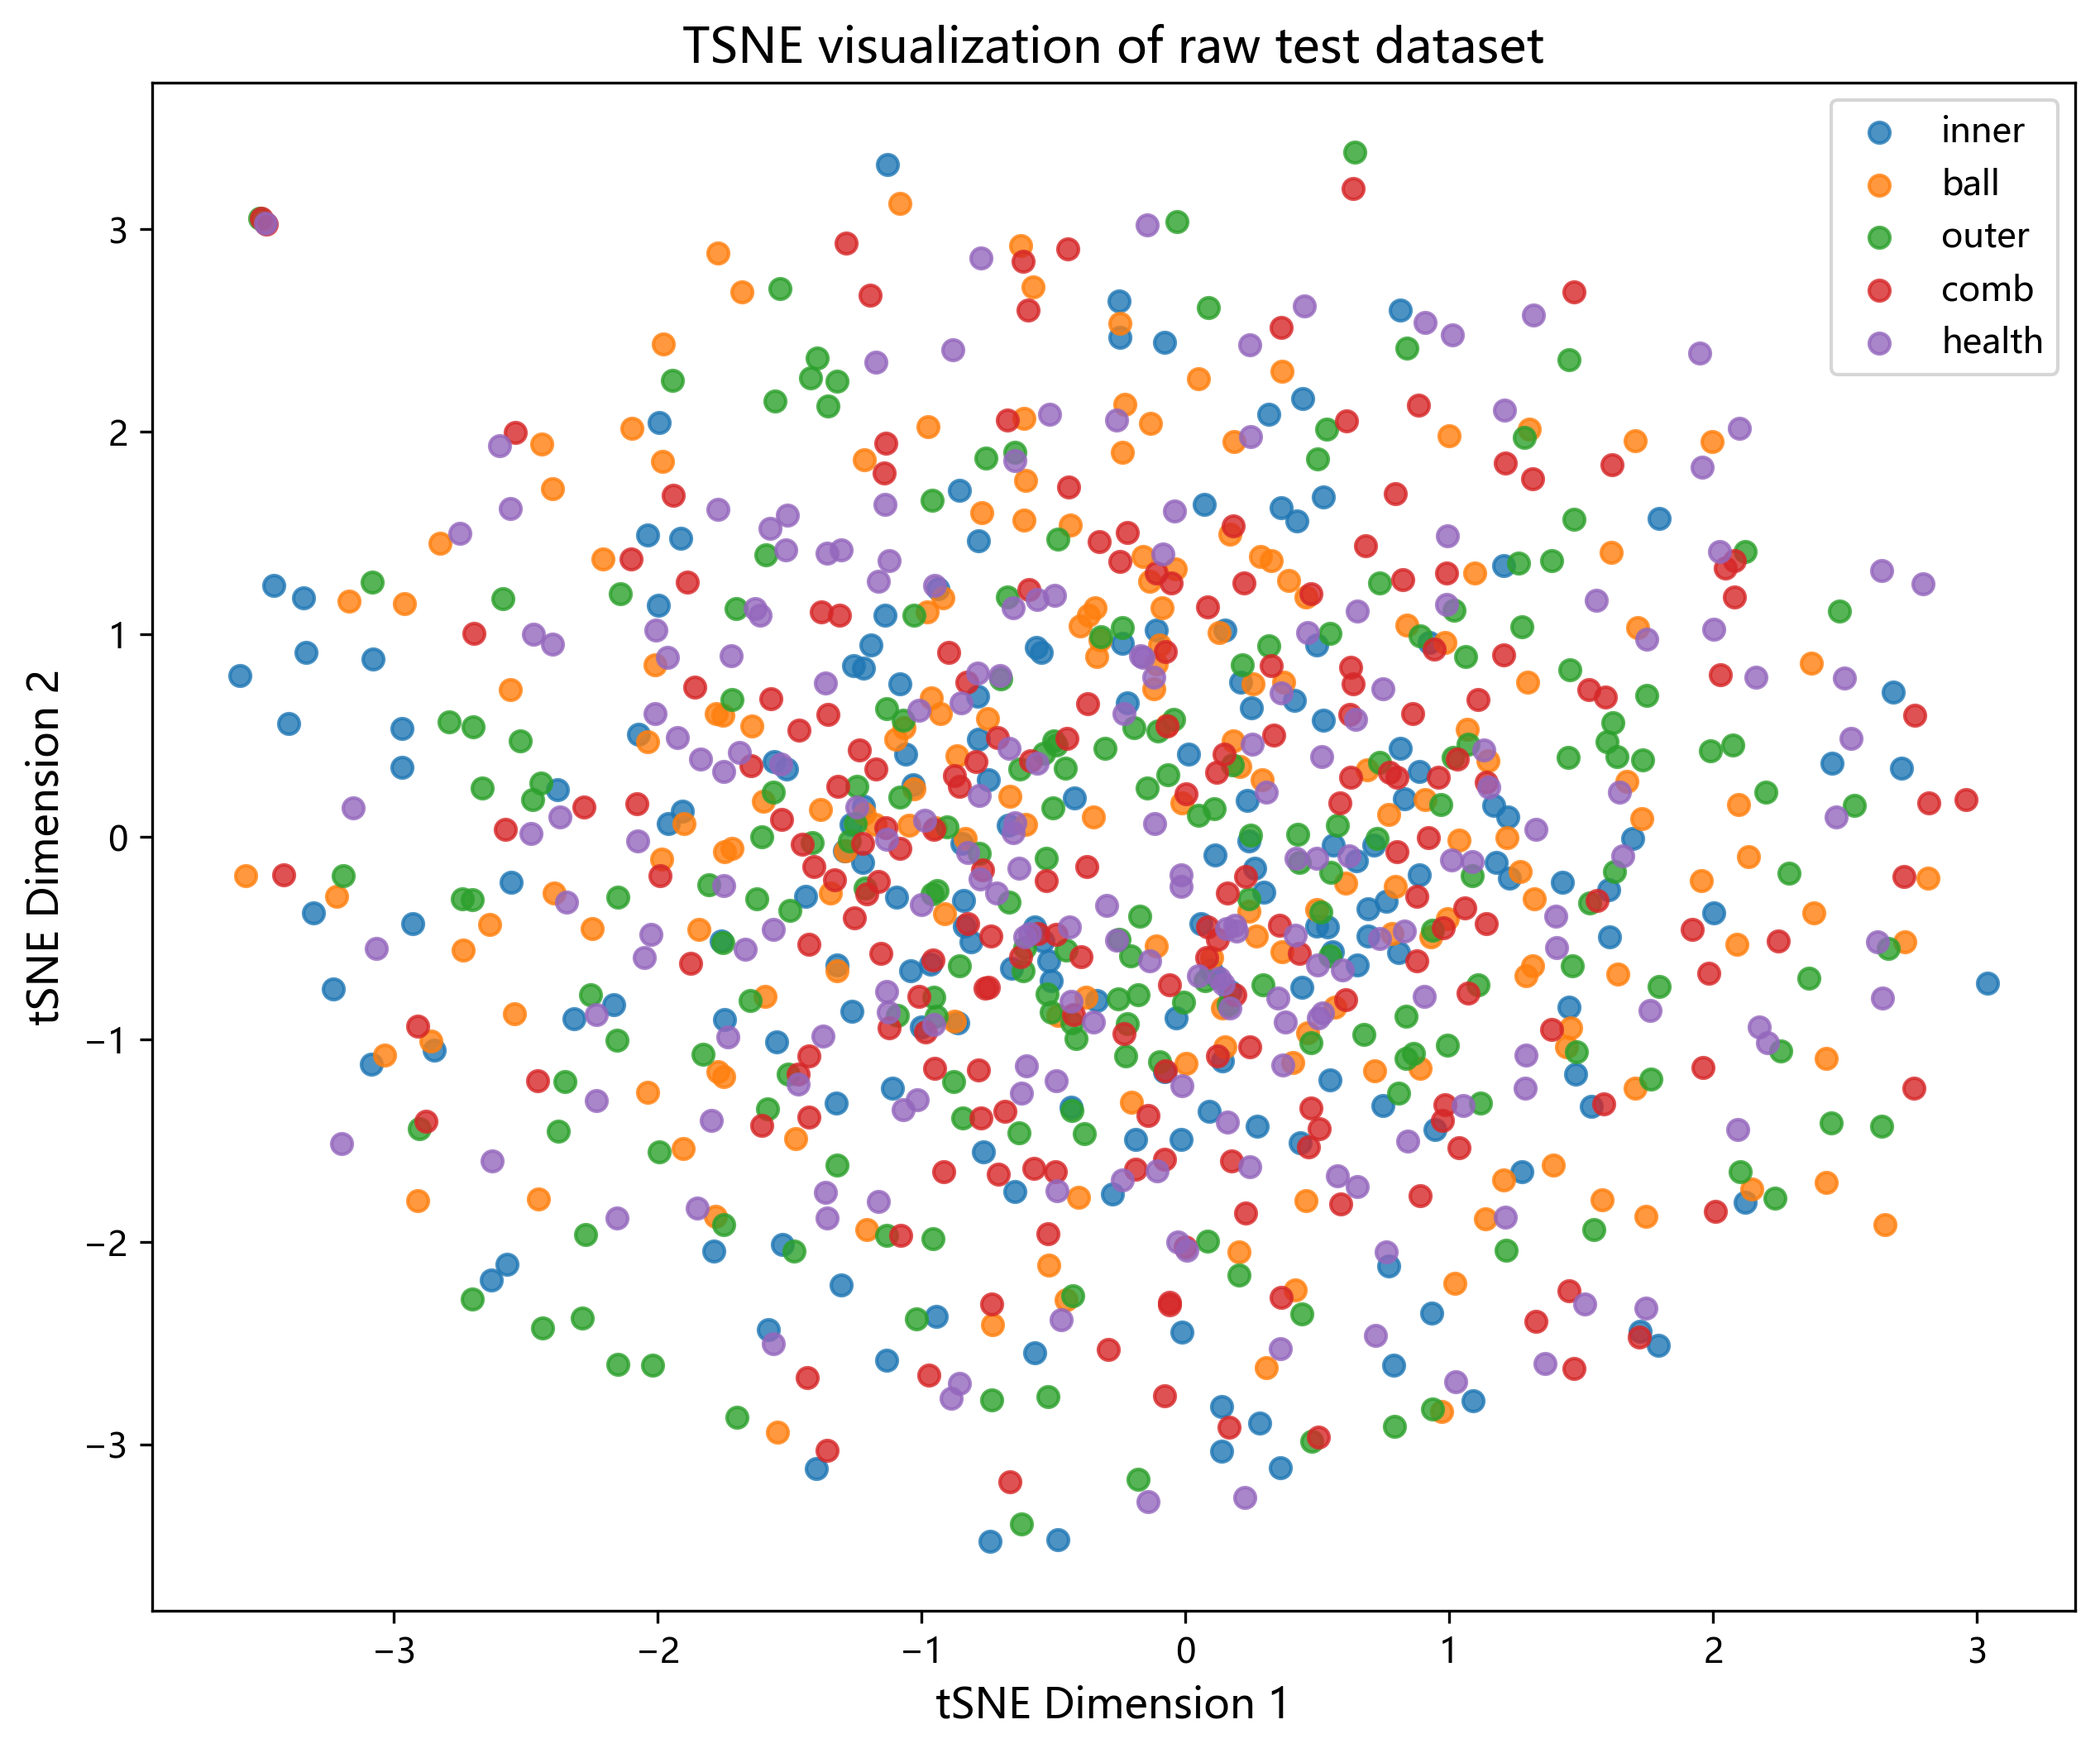

In [21]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')
from sklearn.manifold import TSNE

# 测试集   注意 这里加载 最原始 的数据集， 不加载预处理后的数据
test_x = load('test_xdata')
test_y = load('test_ylabel')

# 加载数据
testloader = Data.DataLoader(dataset=Data.TensorDataset(test_x, test_y),
                                batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_original_features = []  # 原始测试集 特征

for test_data, test_label in testloader:
    test_original_features += test_data.tolist()# 提取特征


    
num_classes = 5  # 5分类
# 类别标签
class_labels_name = ['inner','ball','outer','comb','health']

# 原始 测试集 进行 t-SNE 降维
def plot_orignal_TSNE(test_original_features, test_original_labels, num_classes, class_labels_name):
    features = np.array(test_original_features)
    labels = np.array(test_original_labels)

    # 初始化 t-SNE 模型
    tsne = TSNE(n_components=2, random_state=42)

    # 对原始数据进行 t-SNE 降维
    features_tsne = tsne.fit_transform(features)

    # 可视化结果
    plt.figure(figsize=(10, 8), dpi=300)
    # 绘制每个类别的散点图，并指定label
    for i in range(num_classes):
        plt.scatter(features_tsne[labels == i, 0], features_tsne[labels == i, 1], label=class_labels_name[i], alpha=0.8)
    plt.title('TSNE visualization of raw test dataset', fontsize=14)
    plt.xlabel('tSNE Dimension 1', fontsize=12)
    plt.ylabel('tSNE Dimension 2', fontsize=12)
    # 显示legend
    plt.legend()
    # plt.show()
    plt.savefig('原始测试集TSNE可视化', dpi=300)


# 原始 测试集 进行 t-SNE 降维
plot_orignal_TSNE(test_original_features, test_original_labels, num_classes, class_labels_name)

In [9]:
import torch
import torch.nn.functional as F
from torchview import draw_graph
from SwinCNNSEModel import SwinCNNSEModel  # 替换为你的模型定义
from SEBlock import SEBlock


# 定义模型参数（需与训练代码一致）
conv_archs = ((1, 32), (1, 64), (1, 128))
input_dim = 5
output_dim = 5
num_classes = 5
img_size = 32
patch_size = 4
embed_dim = 64
depths = (1,)
num_heads = (4,)
window_size = 4

# 初始化模型
model = SwinCNNSEModel(
    conv_archs, input_dim, output_dim,
    img_size=img_size,
    patch_size=patch_size,
    in_chans=input_dim,
    num_classes=num_classes,
    embed_dim=embed_dim,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,
    mlp_ratio=2.0
)

# 定义输入维度
batch_size = 64
input_shape = (batch_size, input_dim, 1024)  # 输入张量形状

# 生成网络结构图
model_graph = draw_graph(
    model,
    input_size=input_shape,
    device='meta',       # 不需要实际数据
    hide_module_fields=False,  # 显示层参数
    depth=5,            # 展开层级深度
    graph_name='Swin-CNN-SE',
    save_graph=True,    # 自动保存图片
    directory='./',
    filename='network'
)

# 设置显示参数
model_graph.visual_graph.format = 'png'
model_graph.visual_graph.graph_attr.update({'dpi': 300})
model_graph.visual_graph.node_attr.update({'fontsize': 8})

# 渲染并显示图片
model_graph.visual_graph.render(view=True)

NameError: name 'SEBlock' is not defined

In [1]:
import torch
import torch.nn as nn
from timm.models.swin_transformer import SwinTransformer
from torchview import draw_graph

# ================== 模型定义部分 ==================
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.avg_pool(x)          # [B, C, 1]
        out = out.view(out.size(0), -1) # [B, C]
        out = self.fc1(out)             # [B, C//r]
        out = self.relu(out)
        out = self.fc2(out)             # [B, C]
        out = self.sigmoid(out)         # [B, C]
        out = out.view(out.size(0), out.size(1), -1)  # [B, C, 1]
        return x * out                  # [B, C, L]

class SwinCNNSEModel(nn.Module):
    def __init__(self, conv_archs, input_dim, output_dim, **swin_args):  # 已清除隐藏字符
        super().__init__()
        # SwinTransformer分支
        self.swmodel = SwinTransformer(**swin_args)
        self.adaptive_pool_2D = nn.AdaptiveAvgPool2d((1, 1))
        
        # 1D CNN分支
        self.input_channels = input_dim
        self.cnn1d_globalfeatures = self._make_cnn_layers(conv_archs)
        self.adaptive_pool_1D = nn.AdaptiveAvgPool1d(1)
        
        # 分类层
        self.classifier = nn.Linear(
            swin_args['embed_dim'] + conv_archs[-1][-1], 
            output_dim
        )

    def _make_cnn_layers(self, archs):
        layers = []
        for (num_convs, out_channels) in archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(self.input_channels, out_channels, 3, padding=1),
                    nn.ReLU(),
                    SEBlock(out_channels),
                ]
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(2, 2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Swin分支 [B, C, L=1024] -> [B, C, 32, 32]
        sw_in = x.view(x.size(0), x.size(1), 32, 32)
        sw_feat = self.swmodel.forward_features(sw_in)  # [B, H, W, D]
        sw_feat = sw_feat.permute(0, 3, 1, 2)           # [B, D, H, W]
        sw_out = self.adaptive_pool_2D(sw_feat).flatten(1)
        
        # CNN分支 [B, C, L]
        cnn_feat = self.cnn1d_globalfeatures(x)        # [B, C, L']
        cnn_out = self.adaptive_pool_1D(cnn_feat).flatten(1)
        
        # 特征融合
        combined = torch.cat([sw_out, cnn_out], dim=1)
        return self.classifier(combined)

# ================== 可视化部分 ==================
def visualize_model():
    # 模型参数配置
    model_args = {
        "img_size": 32,
        "patch_size": 4,
        "in_chans": 5,
        "num_classes": 5,
        "embed_dim": 64,
        "depths": (1,),
        "num_heads": (4,),
        "window_size": 4,
        "mlp_ratio": 2.0
    }
    
    # 初始化模型
    model = SwinCNNSEModel(
        conv_archs=((1, 32), (1, 64), (1, 128)),
        input_dim=5,
        output_dim=5,
        **model_args
    )
    
    # 生成结构图
    graph = draw_graph(
        model,
        input_size=(64, 5, 1024),  # 输入维度
        device='meta',             # 不需要实际数据
        hide_module_fields=False,  # 显示层参数
        depth=8,                  # 展开层级深度
        expand_nested=True,       # 展开嵌套结构
        graph_name='Swin-CNN-SE',
        save_graph=True,
        directory='./',
        filename='network_arch'
    )
    
    # 调整显示设置
    graph.visual_graph.graph_attr.update({'dpi': '300'})
    graph.visual_graph.node_attr.update({'fontsize': '9'})
    return graph.render(format='png', view=True)

# ================== 执行可视化 ==================
if __name__ == '__main__':
    # 检查依赖
    try:
        visualize_model()
        print("可视化文件已生成：network_arch.gv.png")
    except Exception as e:
        print(f"错误：{str(e)}")
        print("请确保已安装：")
        print("1. Graphviz (https://graphviz.org/download/)")
        print("2. pip install torchview timm")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "D:\ProgramData\anaconda3\envs\py39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\ProgramData\anaconda3\envs\py39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\ProgramData\anaconda3\envs\py39\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "D:\ProgramData\anaconda3\envs\py39\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  Fil

错误：Failed to run torchgraph see error message
请确保已安装：
1. Graphviz (https://graphviz.org/download/)
2. pip install torchview timm


In [3]:
from graphviz import Digraph
import os

# 检查Graphviz路径配置（Windows需要安装Graphviz客户端）
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # 修改为你的安装路径

# 创建有向图对象
dot = Digraph(comment='Simple Neural Network', format='png')
dot.attr(rankdir='LR')  # 从左到右布局

# 定义网络层样式
layer_style = {
    'shape': 'box',
    'color': 'lightblue2',
    'style': 'filled',
    'fontname': 'Helvetica'
}

# 添加节点 (网络层)
with dot.subgraph(name='input') as c:
    c.node('input', 'Input Layer\n(5 nodes)', shape='ellipse', color='darkseagreen')
    
with dot.subgraph(name='hidden') as c:
    c.node('h1', 'Hidden Layer 1\n(8 nodes)', **layer_style)
    c.node('h2', 'Hidden Layer 2\n(6 nodes)', **layer_style)

with dot.subgraph(name='output') as c:
    c.node('output', 'Output Layer\n(3 nodes)', shape='circle', color='gold')

# 添加连接边
dot.edges([
    ('input', 'h1'),
    ('h1', 'h2'),
    ('h2', 'output')
])

# 添加特殊连接（跳过连接示例）
dot.edge('input', 'h2', color='firebrick', style='dashed', label='Skip Connection')

# 渲染并显示
dot.render('network_graph', view=True, cleanup=True)  # 生成network_graph.png
print("可视化文件已生成：network_graph.png")

可视化文件已生成：network_graph.png


In [10]:
import torch
import torch.nn as nn
from graphviz import Digraph
from timm.models.swin_transformer import SwinTransformer
import os

# 配置Graphviz路径（Windows需要）
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# ================== 模型定义 ==================
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channel, channel // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.avg_pool(x).flatten(1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return x * self.sigmoid(out).unsqueeze(2)

class SwinCNNSEModel(nn.Module):
    def __init__(self, conv_archs, input_dim, output_dim, **swin_args):
        super().__init__()
        # Swin分支
        self.swin = SwinTransformer(**swin_args)
        self.swin_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # CNN分支
        self.cnn = self._make_cnn(conv_archs, input_dim)
        self.cnn_pool = nn.AdaptiveAvgPool1d(1)
        
        # 分类层
        self.classifier = nn.Linear(
            swin_args['embed_dim'] + conv_archs[-1][-1], 
            output_dim
        )

    def _make_cnn(self, archs, in_channels):
        layers = []
        for (num_convs, out_channels) in archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(),
                    SEBlock(out_channels)
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Swin分支
        sw_in = x.view(x.size(0), x.size(1), 32, 32)
        sw_feat = self.swin.forward_features(sw_in)
        sw_out = self.swin_pool(sw_feat.permute(0,3,1,2)).flatten(1)
        
        # CNN分支
        cnn_out = self.cnn_pool(self.cnn(x)).flatten(1)
        
        # 合并
        return self.classifier(torch.cat([sw_out, cnn_out], 1))

# ================== 可视化工具 ==================
def visualize_model(model, input_shape, filename):
    dot = Digraph(name=filename, format='png', graph_attr={
        'rankdir': 'TB',
        'dpi': '150',
        'fontname': 'Helvetica'
    })
    
    # 通用样式（不含shape定义）
    base_style = {
        'style': 'rounded,filled',
        'fontsize': '10',
        'fontname': 'Helvetica'
    }
    
    # 添加输入节点（单独指定shape）
    dot.node('input', f'Input\n{input_shape}', 
            shape='ellipse', 
            color='#FFE4C4',
            **base_style)  # 只传递不冲突的参数
    
    # 添加Swin分支（使用带shape的样式）
    swin_style = {**base_style, 'shape': 'box', 'color': '#87CEFA'}
    with dot.subgraph(name='swin') as s:
        s.node('swin_in', 'Reshape\n(B,5,32,32)', **swin_style)
        s.node('swin_feat', 'Swin Features\n(B,64,8,8)', **swin_style)
        s.node('swin_out', 'Swin Output\n(B,64)', **swin_style)
        s.edges([('input', 'swin_in'), ('swin_in', 'swin_feat'), ('swin_feat', 'swin_out')])
    
    # 添加CNN分支（使用带shape的样式）
    cnn_style = {**base_style, 'shape': 'box', 'color': '#98FB98'}
    with dot.subgraph(name='cnn') as c:
        layers = [
            ('conv1', 'Conv1D\n(B,32,1024)'),
            ('pool1', 'MaxPool1D\n(B,32,512)'),
            ('conv2', 'Conv1D\n(B,64,512)'),
            ('pool2', 'MaxPool1D\n(B,64,256)'),
            ('conv3', 'Conv1D\n(B,128,256)'),
            ('pool3', 'MaxPool1D\n(B,128,128)'),
            ('cnn_out', 'CNN Output\n(B,128)')
        ]
        for node_id, label in layers:
            c.node(node_id, label, **cnn_style)
        c.edges([
            ('input', 'conv1'), ('conv1', 'pool1'),
            ('pool1', 'conv2'), ('conv2', 'pool2'),
            ('pool2', 'conv3'), ('conv3', 'pool3'),
            ('pool3', 'cnn_out')
        ])
    
    # 合并层（特殊形状）
    dot.node('concat', 'Concatenate\n(B,192)', 
            shape='diamond', 
            color='#DDA0DD',
            **base_style)
    dot.node('classifier', 'Classifier\n(B,5)', 
            shape='circle',
            color='#FFB6C1',
            **base_style)
    
    # 连接各节点
    dot.edges([
        ('swin_out', 'concat'),
        ('cnn_out', 'concat'),
        ('concat', 'classifier')
    ])
    
    dot.render(filename, view=True, cleanup=True)

    
# ================== 执行部分 ==================
if __name__ == '__main__':
    # 模型配置
    model = SwinCNNSEModel(
        conv_archs=((1,32), (1,64), (1,128)),
        input_dim=5,
        output_dim=5,
        img_size=32,
        patch_size=4,
        in_chans=5,
        num_classes=5,
        embed_dim=64,
        depths=(1,),
        num_heads=(4,),
        window_size=4,
        mlp_ratio=2.0
    )
    
    # 可视化配置
    input_shape = (64, 5, 1024)  # batch_size=64
    visualize_model(model, input_shape, 'swin_cnn_model')

In [11]:
import torch
import torch.nn as nn
from graphviz import Digraph
from timm.models.swin_transformer import SwinTransformer
import os

# 配置Graphviz路径（Windows需要）
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# ================== 模型定义 ==================
class SEBlock(nn.Module):
    """通道注意力模块"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class SwinCNNSEModel(nn.Module):
    def __init__(self, conv_archs, input_dim, output_dim, **swin_args):
        super().__init__()
        # Swin分支
        self.swin = SwinTransformer(**swin_args)
        self.swin_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # CNN+SE分支
        self.cnn = self._make_cnn_with_se(conv_archs, input_dim)
        self.cnn_pool = nn.AdaptiveAvgPool1d(1)
        
        # 分类层
        self.classifier = nn.Linear(
            swin_args['embed_dim'] + conv_archs[-1][-1], 
            output_dim
        )

    def _make_cnn_with_se(self, archs, in_channels):
        """构建包含SE模块的CNN结构"""
        layers = []
        for (num_convs, out_channels) in archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(),
                    SEBlock(out_channels)  # 关键SE模块添加
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Swin分支（保持不变）
        sw_in = x.view(x.size(0), x.size(1), 32, 32)
        sw_feat = self.swin.forward_features(sw_in)
        sw_out = self.swin_pool(sw_feat.permute(0,3,1,2)).flatten(1)
        
        # CNN+SE分支
        cnn_out = self.cnn_pool(self.cnn(x)).flatten(1)
        
        return self.classifier(torch.cat([sw_out, cnn_out], 1))

# ================== 包含SE模块的可视化 ==================
def visualize_with_se(model, input_shape, filename):
    dot = Digraph(name=filename, format='png', graph_attr={
        'rankdir': 'TB',
        'dpi': '200',
        'nodesep': '0.3',
        'ranksep': '0.4'
    })
    
    # 样式定义
    base_style = {'style': 'rounded,filled', 'fontsize': '10', 'fontname': 'Helvetica'}
    
    # 输入节点
    dot.node('input', f'Input\n{input_shape}', shape='ellipse', color='#FFE4C4', **base_style)
    
    # Swin分支（保持不变）
    with dot.subgraph(name='swin') as s:
        s.node('swin_in', 'Reshape\n(B,5,32,32)', color='#87CEFA', **base_style, shape='box')
        s.node('swin_feat', 'Swin Features\n(B,64,8,8)', color='#4682B4', **base_style, shape='box')
        s.node('swin_out', 'Swin Output\n(B,64)', color='#B0C4DE', **base_style, shape='box')
        s.edges([('input', 'swin_in'), ('swin_in', 'swin_feat'), ('swin_feat', 'swin_out')])
    
    # CNN+SE分支（新增SE模块展示）
    with dot.subgraph(name='cnn_se') as c:
        # 定义各层
        layers = [
            ('conv1', 'Conv1D\n(B,32,1024)', '#98FB98'),
            ('se1', 'SEBlock\n(32→32)', '#FFD700'),  # 新增SE节点
            ('pool1', 'MaxPool1D\n(B,32,512)', '#3CB371'),
            ('conv2', 'Conv1D\n(B,64,512)', '#98FB98'),
            ('se2', 'SEBlock\n(64→64)', '#FFD700'),  # 新增SE节点
            ('pool2', 'MaxPool1D\n(B,64,256)', '#3CB371'),
            ('conv3', 'Conv1D\n(B,128,256)', '#98FB98'),
            ('se3', 'SEBlock\n(128→128)', '#FFD700'),  # 新增SE节点
            ('pool3', 'MaxPool1D\n(B,128,128)', '#3CB371'),
            ('cnn_out', 'CNN Output\n(B,128)', '#B0C4DE')
        ]
        
        # 添加节点
        for node_id, label, color in layers:
            c.node(node_id, label, color=color, **base_style, shape='box')
        
        # 连接关系（包含SE模块）
        connections = [
            ('input', 'conv1'),
            ('conv1', 'se1'),
            ('se1', 'pool1'),   # Conv后接SE
            ('pool1', 'conv2'),
            ('conv2', 'se2'),
            ('se2', 'pool2'),
            ('pool2', 'conv3'),
            ('conv3', 'se3'),
            ('se3', 'pool3'),
            ('pool3', 'cnn_out')
        ]
        c.edges(connections)
    
    # 合并层和分类器（保持不变）
    dot.node('concat', 'Concatenate\n(B,192)', shape='diamond', color='#DDA0DD', **base_style)
    dot.node('classifier', 'Classifier\n(B,5)', shape='circle', color='#FFB6C1', **base_style)
    dot.edges([('swin_out', 'concat'), ('cnn_out', 'concat'), ('concat', 'classifier')])
    
    dot.render(filename, view=True, cleanup=True)
    print(f"可视化文件已生成：{filename}.png")

# ================== 执行部分 ==================
if __name__ == '__main__':
    # 初始化模型
    model = SwinCNNSEModel(
        conv_archs=((1,32), (1,64), (1,128)),
        input_dim=5,
        output_dim=5,
        img_size=32,
        patch_size=4,
        in_chans=5,
        num_classes=5,
        embed_dim=64,
        depths=(1,),
        num_heads=(4,),
        window_size=4,
        mlp_ratio=2.0
    )
    
    # 执行可视化
    visualize_with_se(model, (64,5,1024), 'swin_cnn_se_model')

可视化文件已生成：swin_cnn_se_model.png


In [ ]:
### 下面是横向的可视化

In [5]:
import torch
import torch.nn as nn
from graphviz import Digraph
from timm.models.swin_transformer import SwinTransformer
import os

# 配置Graphviz路径（Windows需要）
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# ================== 模型定义 ==================
class SEBlock(nn.Module):
    """通道注意力模块"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class SwinCNNSEModel(nn.Module):
    def __init__(self, conv_archs, input_dim, output_dim, **swin_args):
        super().__init__()
        # Swin分支
        self.swin = SwinTransformer(**swin_args)
        self.swin_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # CNN+SE分支
        self.cnn = self._make_cnn_with_se(conv_archs, input_dim)
        self.cnn_pool = nn.AdaptiveAvgPool1d(1)
        
        # 分类层
        self.classifier = nn.Linear(
            swin_args['embed_dim'] + conv_archs[-1][-1], 
            output_dim
        )

    def _make_cnn_with_se(self, archs, in_channels):
        """构建包含SE模块的CNN结构"""
        layers = []
        for (num_convs, out_channels) in archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(),
                    SEBlock(out_channels)  # 关键SE模块添加
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Swin分支（保持不变）
        sw_in = x.view(x.size(0), x.size(1), 32, 32)
        sw_feat = self.swin.forward_features(sw_in)
        sw_out = self.swin_pool(sw_feat.permute(0,3,1,2)).flatten(1)
        
        # CNN+SE分支
        cnn_out = self.cnn_pool(self.cnn(x)).flatten(1)
        
        return self.classifier(torch.cat([sw_out, cnn_out], 1))

# ================== 包含SE模块的可视化 ==================
def visualize_with_se(model, input_shape, filename):
    dot = Digraph(name=filename, format='png', graph_attr={
        'rankdir': 'LR',
        'dpi': '200',
        'nodesep': '0.1',    # 减小节点间距
        'ranksep': '1.0',    # 增加层级间距
        'size': '30,15'      # 增加画布尺寸（宽30英寸，高15英寸）
    })
    
    # 样式定义（保持不变）
    base_style = {'style': 'rounded,filled', 'fontsize': '10', 'fontname': 'Helvetica'}
    
    # 输入节点（添加位置约束）
    with dot.subgraph() as s:
        s.attr(rank='min')  # 输入层位于最左侧
        s.node('input', f'Input\n{input_shape}', shape='ellipse', color='#FFE4C4', **base_style)
    
    # Swin分支（保持在同一垂直层级）
    with dot.subgraph(name='swin') as s:
        s.attr(rank='same')  # 使Swin分支节点水平排列
        s.node('swin_in', 'Reshape\n(B,5,32,32)', color='#87CEFA', **base_style, shape='box')
        s.node('swin_feat', 'Swin Features\n(B,64,8,8)', color='#4682B4', **base_style, shape='box')
        s.node('swin_out', 'Swin Output\n(B,64)', color='#B0C4DE', **base_style, shape='box')
        s.edges([('swin_in', 'swin_feat'), ('swin_feat', 'swin_out')])
    
   # 修改CNN+SE分支为垂直排列
    with dot.subgraph(name='cnn_se') as c:
        c.attr(rankdir='TB')  # 子图内部使用垂直布局
        layers = [
            ('conv1', 'Conv1D\n(B,32,1024)', '#98FB98'),
            ('se1', 'SEBlock', '#FFD700'),    # 简化标签
            ('pool1', 'MaxPool1D\n512', '#3CB371'),
            ('conv2', 'Conv1D\n64', '#98FB98'),
            ('se2', 'SEBlock', '#FFD700'),
            ('pool2', 'MaxPool1D\n256', '#3CB371'),
            ('conv3', 'Conv1D\n128', '#98FB98'),
            ('se3', 'SEBlock', '#FFD700'),
            ('pool3', 'MaxPool1D\n128', '#3CB371'),
            ('cnn_out', 'CNN Output', '#B0C4DE')
        ]
        
        # 添加垂直连接
        prev_node = 'input'
        for node_id, label, color in layers:
            c.node(node_id, label, color=color, **base_style, shape='box')
            c.edge(prev_node, node_id)
            prev_node = node_id
    
    # 合并层与分类器的位置调整
    with dot.subgraph() as s:
        s.attr(rank='max')  # 输出层位于最右侧
        s.node('concat', 'Concatenate\n(B,192)', shape='diamond', color='#DDA0DD', **base_style)
        s.node('classifier', 'Classifier\n(B,5)', shape='circle', color='#FFB6C1', **base_style)
    
    # 连接关系调整
    dot.edges([
        ('input', 'swin_in'),
        ('input', 'conv1'),  # CNN分支起始
        ('swin_out', 'concat'),
        ('cnn_out', 'concat'),
        ('concat', 'classifier')
    ])
    
    # 渲染保持不变
    dot.render(filename, view=True, cleanup=True)

# ================== 执行部分 ==================
if __name__ == '__main__':
    # 初始化模型
    model = SwinCNNSEModel(
        conv_archs=((1,32), (1,64), (1,128)),
        input_dim=5,
        output_dim=5,
        img_size=32,
        patch_size=4,
        in_chans=5,
        num_classes=5,
        embed_dim=64,
        depths=(1,),
        num_heads=(4,),
        window_size=4,
        mlp_ratio=2.0
    )
    
    # 执行可视化
    visualize_with_se(model, (64,5,1024), 'swin_cnn_se_model')

In [3]:
def visualize_with_se(model, input_shape, filename):
    dot = Digraph(name=filename, format='png', engine='neato', graph_attr={
        'rankdir': 'LR',     # 全局横向布局
        'dpi': '200',
        'nodesep': '0.2',
        'ranksep': '1.5',    # 增大层级间距
        'overlap': 'false'   # 禁止节点重叠
    })
    
    # 基础样式
    base_style = {
        'style': 'rounded,filled',
        'fontname': 'Helvetica',
        'fontsize': '10',
        'height': '0.5',
        'width': '2.0'
    }
    
    # 输入节点
    dot.node('input', f'Input\n{input_shape}', 
            shape='ellipse', color='#FFE4C4', **base_style)
    
    # ================== Swin 分支优化 ==================
    with dot.subgraph(name='swin') as s:
        s.attr(rank='same')  # 关键修改：强制水平排列
        # 节点定义
        nodes = [
            ('swin_in', 'Reshape\n(5,32,32)', '#87CEFA'),
            ('swin_attn', 'Window\nAttention', '#4682B4'),
            ('swin_mlp', 'MLP', '#4682B4'),
            ('swin_out', 'Swin Output', '#B0C4DE')
        ]
        # 添加节点
        for node_id, label, color in nodes:
            s.node(node_id, label, shape='box', color=color, **base_style)
        # 水平连接
        s.edges([('swin_in', 'swin_attn'), 
                ('swin_attn', 'swin_mlp'),
                ('swin_mlp', 'swin_out')])
    
    # ================== CNN+SE 分支优化 ==================
    with dot.subgraph(name='cnn') as c:
        c.attr(rankdir='TB', rank='same')  # 垂直排列但同一层级
        # 节点定义（简化标签）
        layers = [
            ('conv1', 'Conv1D', '#98FB98'),
            ('se1', 'SE', '#FFD700'),
            ('pool1', 'MaxPool', '#3CB371'),
            ('conv2', 'Conv1D', '#98FB98'),
            ('se2', 'SE', '#FFD700'),
            ('pool2', 'MaxPool', '#3CB371'),
            ('cnn_out', 'CNN Out', '#B0C4DE')
        ]
        # 添加垂直连接
        prev = 'input'
        for node_id, label, color in layers:
            c.node(node_id, label, shape='box', color=color, **base_style)
            c.edge(prev, node_id)
            prev = node_id
    
    # ================== 合并层优化 ==================
    with dot.subgraph() as m:
        m.attr(rank='same')
        m.node('concat', 'Concat', shape='diamond', color='#DDA0DD', **base_style)
        m.node('cls', 'Classifier', shape='circle', color='#FFB6C1', **base_style)
        m.edge('concat', 'cls')
    
    # 跨分支连接
    dot.edges([
        ('input', 'swin_in'),
        ('swin_out', 'concat'),
        ('cnn_out', 'concat')
    ])

    # 渲染输出
    dot.render(filename, view=True, cleanup=True, format='png')

In [8]:
import torch
import torch.nn as nn
from graphviz import Digraph
from timm.models.swin_transformer import SwinTransformer
import os

# 配置Graphviz路径（Windows需要）
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# ================== 模型定义 ==================
class SEBlock(nn.Module):
    """通道注意力模块"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class SwinCNNSEModel(nn.Module):
    def __init__(self, conv_archs, input_dim, output_dim, **swin_args):
        super().__init__()
        # Swin分支
        self.swin = SwinTransformer(**swin_args)
        self.swin_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # CNN+SE分支
        self.cnn = self._make_cnn_with_se(conv_archs, input_dim)
        self.cnn_pool = nn.AdaptiveAvgPool1d(1)
        
        # 分类层
        self.classifier = nn.Linear(
            swin_args['embed_dim'] + conv_archs[-1][-1], 
            output_dim
        )

    def _make_cnn_with_se(self, archs, in_channels):
        """构建包含SE模块的CNN结构"""
        layers = []
        for (num_convs, out_channels) in archs:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, 3, padding=1),
                    nn.ReLU(),
                    SEBlock(out_channels)  # 关键SE模块添加
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(2))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Swin分支（保持不变）
        sw_in = x.view(x.size(0), x.size(1), 32, 32)
        sw_feat = self.swin.forward_features(sw_in)
        sw_out = self.swin_pool(sw_feat.permute(0,3,1,2)).flatten(1)
        
        # CNN+SE分支
        cnn_out = self.cnn_pool(self.cnn(x)).flatten(1)
        
        return self.classifier(torch.cat([sw_out, cnn_out], 1))

# ================== 包含SE模块的可视化 ==================
def visualize_with_se(model, input_shape, filename):
    dot = Digraph(name=filename, format='png', engine='neato', graph_attr={
        'rankdir': 'LR',     # 全局横向布局
        'dpi': '200',
        'nodesep': '0.2',
        'ranksep': '1.5',    # 增大层级间距
        'overlap': 'false'   # 禁止节点重叠
    })
    
    # 基础样式
    base_style = {
        'style': 'rounded,filled',
        'fontname': 'Helvetica',
        'fontsize': '10',
        'height': '0.5',
        'width': '2.0'
    }
    
    # 输入节点
    dot.node('input', f'Input\n{input_shape}', 
            shape='ellipse', color='#FFE4C4', **base_style)
    
    # ================== Swin 分支优化 ==================
    with dot.subgraph(name='swin') as s:
        s.attr(rank='same')  # 关键修改：强制水平排列
        # 节点定义
        nodes = [
            ('swin_in', 'Reshape\n(5,32,32)', '#87CEFA'),
            ('swin_attn', 'Window\nAttention', '#4682B4'),
            ('swin_mlp', 'MLP', '#4682B4'),
            ('swin_out', 'Swin Output', '#B0C4DE')
        ]
        # 添加节点
        for node_id, label, color in nodes:
            s.node(node_id, label, shape='box', color=color, **base_style)
        # 水平连接
        s.edges([('swin_in', 'swin_attn'), 
                ('swin_attn', 'swin_mlp'),
                ('swin_mlp', 'swin_out')])
    
    # ================== CNN+SE 分支优化 ==================
    with dot.subgraph(name='cnn') as c:
        c.attr(rankdir='TB', rank='same')  # 垂直排列但同一层级
        # 节点定义（简化标签）
        layers = [
            ('conv1', 'Conv1D', '#98FB98'),
            ('se1', 'SE', '#FFD700'),
            ('pool1', 'MaxPool', '#3CB371'),
            ('conv2', 'Conv1D', '#98FB98'),
            ('se2', 'SE', '#FFD700'),
            ('pool2', 'MaxPool', '#3CB371'),
            ('cnn_out', 'CNN Out', '#B0C4DE')
        ]
        # 添加垂直连接
        prev = 'input'
        for node_id, label, color in layers:
            c.node(node_id, label, shape='box', color=color, **base_style)
            c.edge(prev, node_id)
            prev = node_id
    
    # ================== 合并层优化 ==================
    with dot.subgraph() as m:
        m.attr(rank='same')
        m.node('concat', 'Concat', shape='diamond', color='#DDA0DD', **base_style)
        m.node('cls', 'Classifier', shape='circle', color='#FFB6C1', **base_style)
        m.edge('concat', 'cls')
    
    # 跨分支连接
    dot.edges([
        ('input', 'swin_in'),
        ('swin_out', 'concat'),
        ('cnn_out', 'concat')
    ])

    # 渲染输出
    dot.render(filename, view=True, cleanup=True, format='png')

# ================== 执行部分 ==================
if __name__ == '__main__':
    # 初始化模型
    model = SwinCNNSEModel(
        conv_archs=((1,32), (1,64), (1,128)),
        input_dim=5,
        output_dim=5,
        img_size=32,
        patch_size=4,
        in_chans=5,
        num_classes=5,
        embed_dim=64,
        depths=(1,),
        num_heads=(4,),
        window_size=4,
        mlp_ratio=2.0
    )
    
    # 执行可视化
    visualize_with_se(model, (64,5,1024), 'swin_cnn_se_model')